这个仿真程序实现了以下功能：

时钟模型：

GM使用理想时钟
其他节点使用具有相同漂移率的非理想时钟
考虑时钟粒度(8ns)的影响
两步法同步过程：

GM定期(31.25ms)生成同步消息
消息沿链路逐跳传递
每个节点处理同步消息并调整时钟
更新修正域和速率比率
误差来源模拟：

物理层抖动(0-8ns均匀分布)
时钟粒度影响
链路延迟测量误差
速率比率测量误差(±0.1ppm)
驻留时间的随机变化
数据分析：

跟踪每个节点的时钟偏差
分析同步精度随跳数的变化
可视化代表性节点的时钟偏差变化
这个仿真将展示跳数如何影响同步精度，特别是物理层抖动和时钟粒度的累积效应。可以修改参数值(如漂移率、同步间隔等)来研究不同条件下的同步性能。

使用共同漂移率: 5.0 ppm


D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38047 (\N{CJK UNIFIED IDEOGRAPH-949F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packa

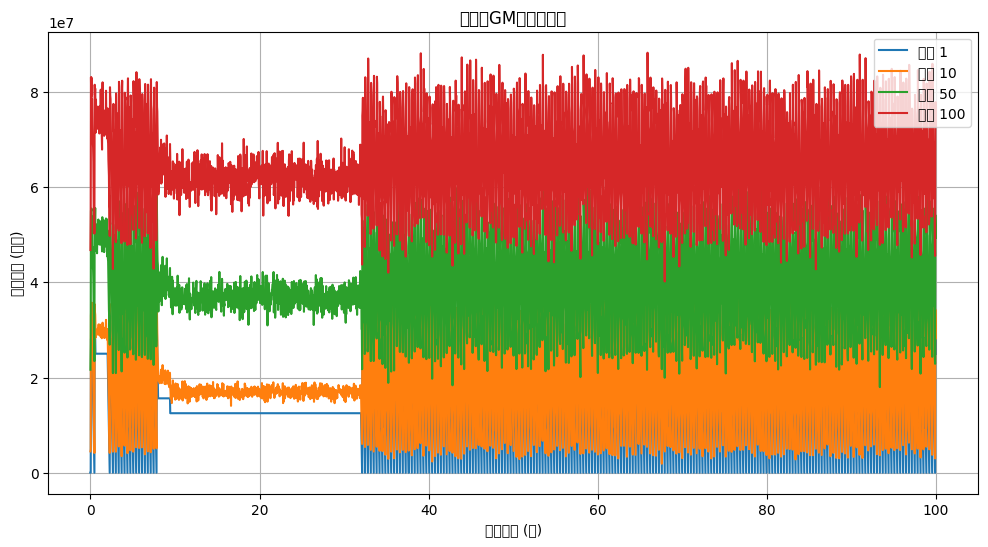

D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\06_engineering\03_analysis\pj_large_scale\venv\Lib\site-packa

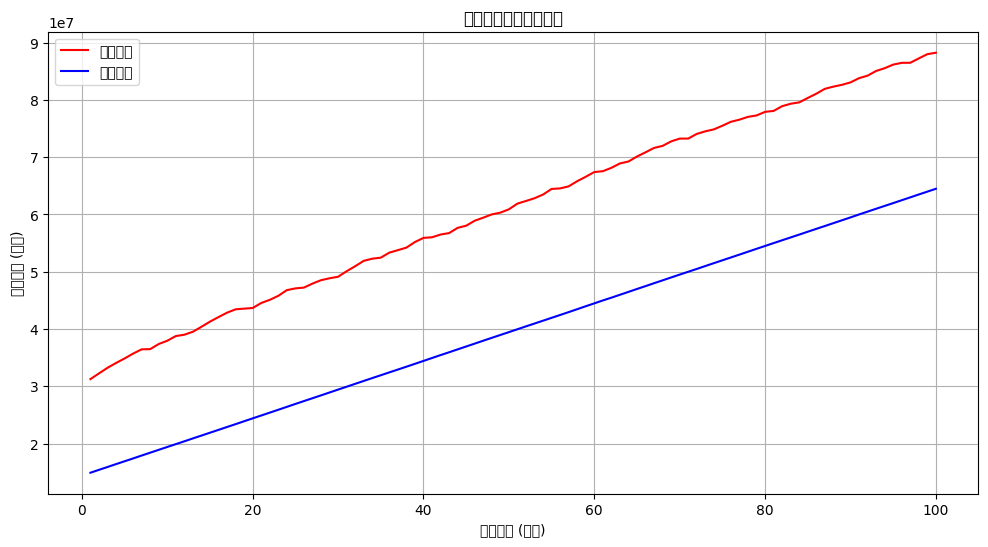

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 100  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 带漂移的时钟更新
            real_elapsed = elapsed_sim_time * (1 + self.drift_rate)
            self.time += real_elapsed
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self, common_drift_rate=None):
        # 创建节点
        self.nodes = []
        
        # 如果未指定共同漂移率，则使用随机值
        if common_drift_rate is None:
            common_drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
        print(f"使用共同漂移率: {common_drift_rate*1e6} ppm")
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点
        for i in range(1, NUM_NODES):
            node = Bridge(i, common_drift_rate)
            self.nodes.append(node)
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录GM的真实时间
        self.gm_times = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(time_step)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % SYNC_INTERVAL < time_step:
                gm_time = self.nodes[0].clock.get_time()
                self.gm_times.append((self.sim_time, gm_time))
                
                for i in range(1, NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    offset = local_time - gm_time
                    self.nodes[i].clock_offsets.append((self.sim_time, offset))
                    
                    # 记录相对于理想时间的真实偏差
                    true_offset = local_time - self.sim_time
                    self.nodes[i].true_offsets.append((self.sim_time, true_offset))
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for time, offset in self.nodes[i].clock_offsets if time > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制时钟偏差
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = [t for t, _ in self.nodes[i].clock_offsets]
            offsets = [o*1e9 for _, o in self.nodes[i].clock_offsets]  # 转换为纳秒
            plt.plot(times, offsets, label=f"节点 {i}")
        
        plt.xlabel("仿真时间 (秒)")
        plt.ylabel("时钟偏差 (纳秒)")
        plt.title("相对于GM的时钟偏差")
        plt.legend()
        plt.grid(True)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in max_offsets], 'r-', label="最大偏差")
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in avg_offsets], 'b-', label="平均偏差")
        plt.xlabel("节点编号 (跳数)")
        plt.ylabel("时钟偏差 (纳秒)")
        plt.title("同步精度与跳数的关系")
        plt.legend()
        plt.grid(True)
        
        plt.show()

# 运行仿真
# 所有非GM节点使用相同的漂移率
common_drift_rate = 5e-6  # 5ppm
sim = Simulator(common_drift_rate)
sim.run()
sim.plot_results()


1、所有的节点的数据都保存到output_data文件下面的csv中，每个节点存在单独的一列中。
2、所有的数据在保存的时候都保存成微秒单位，并保留小数点后3位。
3、所有的注释都用中文，然后所有的的图的具体内容都用英文。
 --thinking_budget 16384

使用共同漂移率: 5.0 ppm
数据已保存到output_data文件夹中


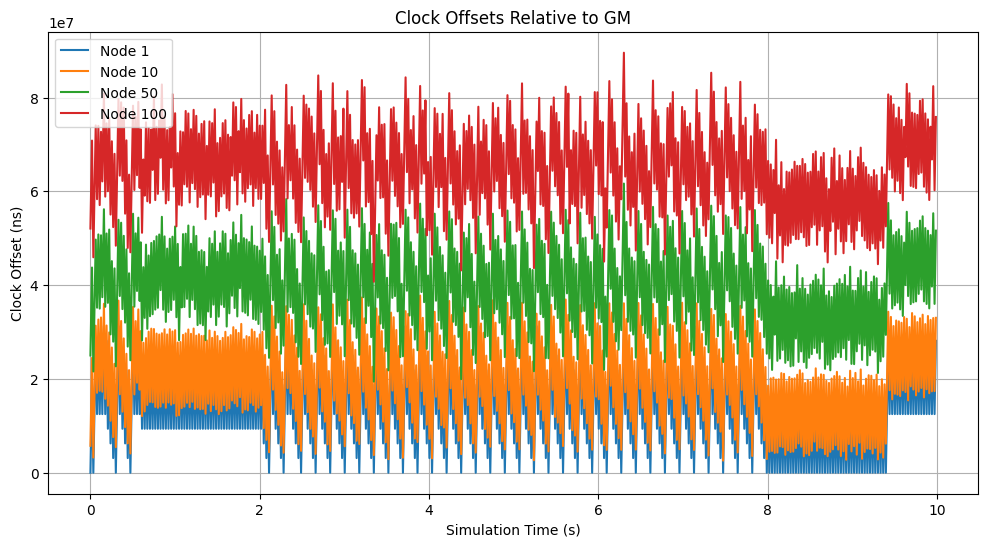

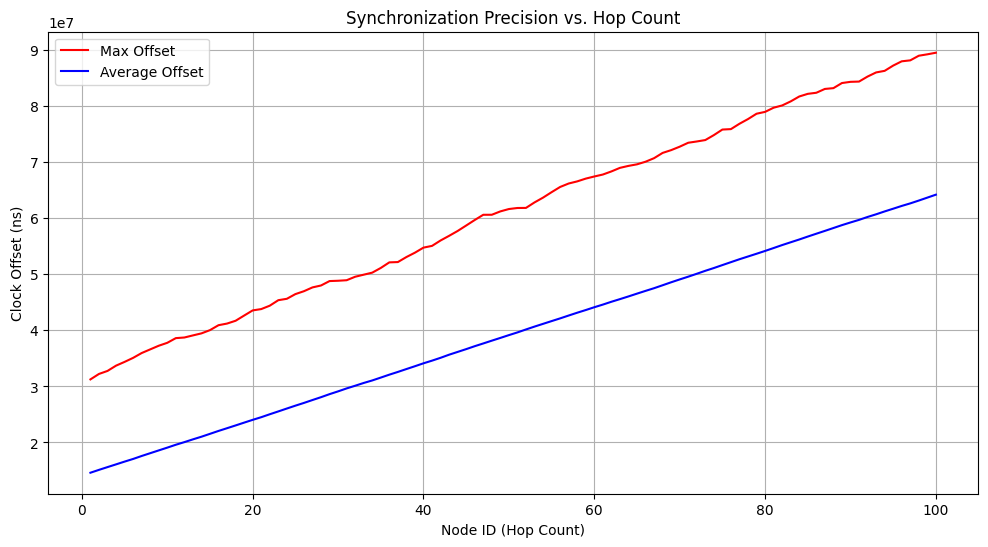

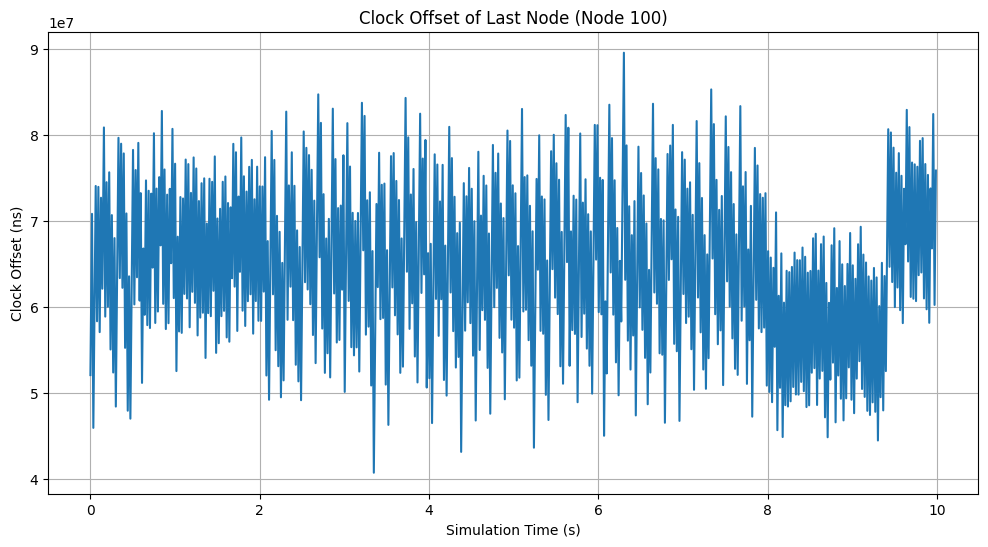

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import pandas as pd

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 10  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

# 创建输出目录
os.makedirs('output_data', exist_ok=True)

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 带漂移的时钟更新
            real_elapsed = elapsed_sim_time * (1 + self.drift_rate)
            self.time += real_elapsed
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
        self.clock_times = []  # 记录时钟时间
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self, common_drift_rate=None):
        # 创建节点
        self.nodes = []
        
        # 如果未指定共同漂移率，则使用随机值
        if common_drift_rate is None:
            common_drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
        print(f"使用共同漂移率: {common_drift_rate*1e6} ppm")
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点
        for i in range(1, NUM_NODES):
            node = Bridge(i, common_drift_rate)
            self.nodes.append(node)
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录仿真时间点
        self.sim_time_points = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(time_step)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % (SYNC_INTERVAL/2) < time_step:  # 每半个同步周期记录一次数据
                self.sim_time_points.append(self.sim_time)
                gm_time = self.nodes[0].clock.get_time()
                
                for i in range(NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    self.nodes[i].clock_times.append(local_time)
                    
                    if i > 0:  # 非GM节点
                        offset = local_time - gm_time
                        self.nodes[i].clock_offsets.append(offset)
                        
                        # 记录相对于理想时间的真实偏差
                        true_offset = local_time - self.sim_time
                        self.nodes[i].true_offsets.append(true_offset)
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def save_data_to_csv(self):
        """保存数据到CSV文件"""
        # 保存时钟时间
        clock_times_data = {}
        clock_times_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为微秒并保留3位小数
            clock_times_data[f'node_{i}'] = [round(t * 1e6, 3) for t in self.nodes[i].clock_times]
        
        # 创建DataFrame并保存
        df_times = pd.DataFrame(clock_times_data)
        df_times.to_csv('output_data/clock_times.csv', index=False)
        
        # 保存时钟偏差
        offsets_data = {}
        offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].clock_offsets]
        
        # 创建DataFrame并保存
        df_offsets = pd.DataFrame(offsets_data)
        df_offsets.to_csv('output_data/clock_offsets.csv', index=False)
        
        # 保存真实偏差
        true_offsets_data = {}
        true_offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            true_offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].true_offsets]
        
        # 创建DataFrame并保存
        df_true = pd.DataFrame(true_offsets_data)
        df_true.to_csv('output_data/true_offsets.csv', index=False)
        
        print("数据已保存到output_data文件夹中")
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for t_idx, offset in enumerate(self.nodes[i].clock_offsets) 
                             if self.sim_time_points[t_idx] > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        # 保存同步精度结果
        precision_data = {
            'node_id': list(range(1, NUM_NODES)),
            'max_offset_us': [round(o * 1e6, 3) for o in max_offsets],  # 转换为微秒并保留3位小数
            'avg_offset_us': [round(o * 1e6, 3) for o in avg_offsets]   # 转换为微秒并保留3位小数
        }
        
        df_precision = pd.DataFrame(precision_data)
        df_precision.to_csv('output_data/sync_precision.csv', index=False)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制时钟偏差
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = self.sim_time_points
            offsets = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
            plt.plot(times, offsets, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Clock Offsets Relative to GM")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/clock_offsets.png', dpi=300)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in max_offsets], 'r-', label="Max Offset")
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in avg_offsets], 'b-', label="Average Offset")
        plt.xlabel("Node ID (Hop Count)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Synchronization Precision vs. Hop Count")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/sync_precision.png', dpi=300)
        
        # 绘制最后一个节点的偏差随时间的变化
        plt.figure(figsize=(12, 6))
        times = self.sim_time_points
        offsets = [o*1e9 for o in self.nodes[-1].clock_offsets]  # 转换为纳秒
        plt.plot(times, offsets)
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Clock Offset (ns)")
        plt.title(f"Clock Offset of Last Node (Node {NUM_NODES-1})")
        plt.grid(True)
        plt.savefig('output_data/last_node_offset.png', dpi=300)
        
        plt.show()

# 运行仿真
# 所有非GM节点使用相同的漂移率
common_drift_rate = 5e-6  # 5ppm
sim = Simulator(common_drift_rate)
sim.run()
sim.save_data_to_csv()
sim.plot_results()

我想在这个代码基础上继续修改。每个节点拥有独立的漂移率，他们最大的漂移率为10ppm，drift_rate_changed 为-1,1ppm/s。 --thinking_budget 16384

节点 1 - 初始漂移率: 7.514 ppm, 漂移率变化: 0.902 ppm/s
节点 2 - 初始漂移率: -3.922 ppm, 漂移率变化: 0.156 ppm/s
节点 3 - 初始漂移率: 0.572 ppm, 漂移率变化: 0.962 ppm/s
节点 4 - 初始漂移率: 9.049 ppm, 漂移率变化: 0.102 ppm/s
节点 5 - 初始漂移率: 6.355 ppm, 漂移率变化: 0.690 ppm/s
节点 6 - 初始漂移率: -8.901 ppm, 漂移率变化: 0.302 ppm/s
节点 7 - 初始漂移率: -6.845 ppm, 漂移率变化: -0.803 ppm/s
节点 8 - 初始漂移率: 3.029 ppm, 漂移率变化: -0.941 ppm/s
节点 9 - 初始漂移率: -9.680 ppm, 漂移率变化: -0.216 ppm/s
节点 10 - 初始漂移率: -9.944 ppm, 漂移率变化: 0.141 ppm/s
节点 11 - 初始漂移率: -5.535 ppm, 漂移率变化: 0.829 ppm/s
节点 12 - 初始漂移率: 7.188 ppm, 漂移率变化: 0.134 ppm/s
节点 13 - 初始漂移率: -2.757 ppm, 漂移率变化: 0.497 ppm/s
节点 14 - 初始漂移率: -5.625 ppm, 漂移率变化: -0.518 ppm/s
节点 15 - 初始漂移率: 8.620 ppm, 漂移率变化: -0.205 ppm/s
节点 16 - 初始漂移率: 0.444 ppm, 漂移率变化: 0.493 ppm/s
节点 17 - 初始漂移率: 3.409 ppm, 漂移率变化: -0.293 ppm/s
节点 18 - 初始漂移率: -2.206 ppm, 漂移率变化: -0.562 ppm/s
节点 19 - 初始漂移率: 5.940 ppm, 漂移率变化: 0.435 ppm/s
节点 20 - 初始漂移率: 7.378 ppm, 漂移率变化: 0.361 ppm/s
节点 21 - 初始漂移率: -8.262 ppm, 漂移率变化: -0.170 ppm/s
节点 22 - 初始漂移率: 5.707 ppm, 漂移率变化: -0.406 ppm/s


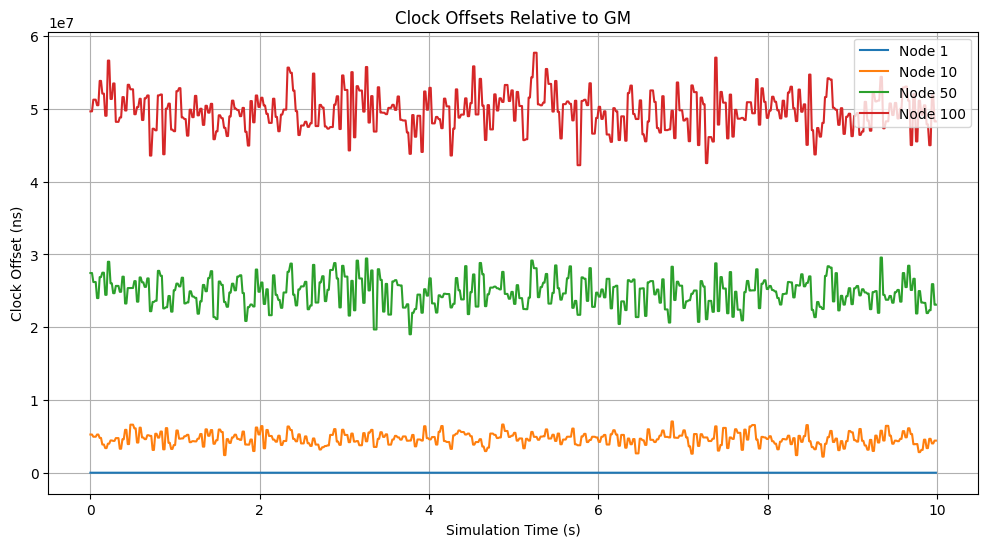

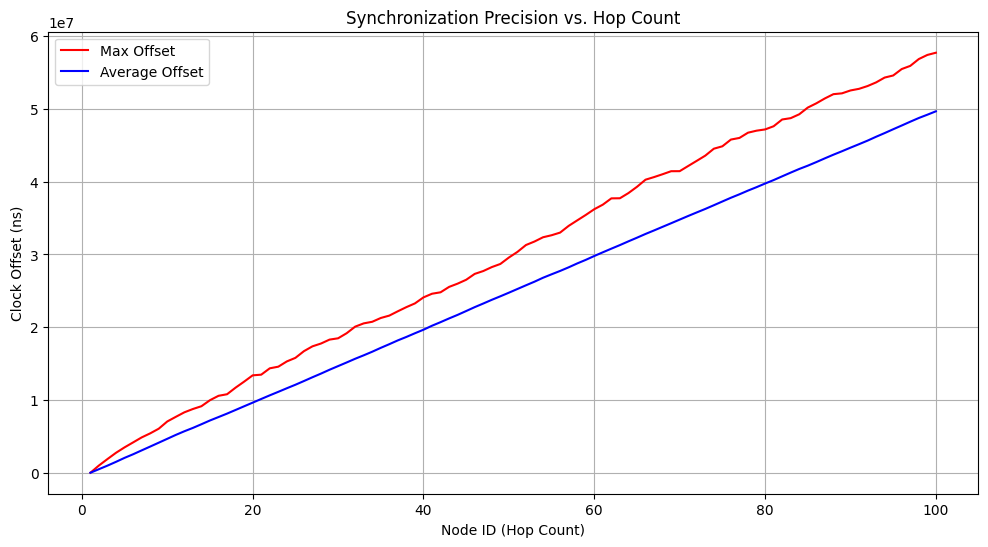

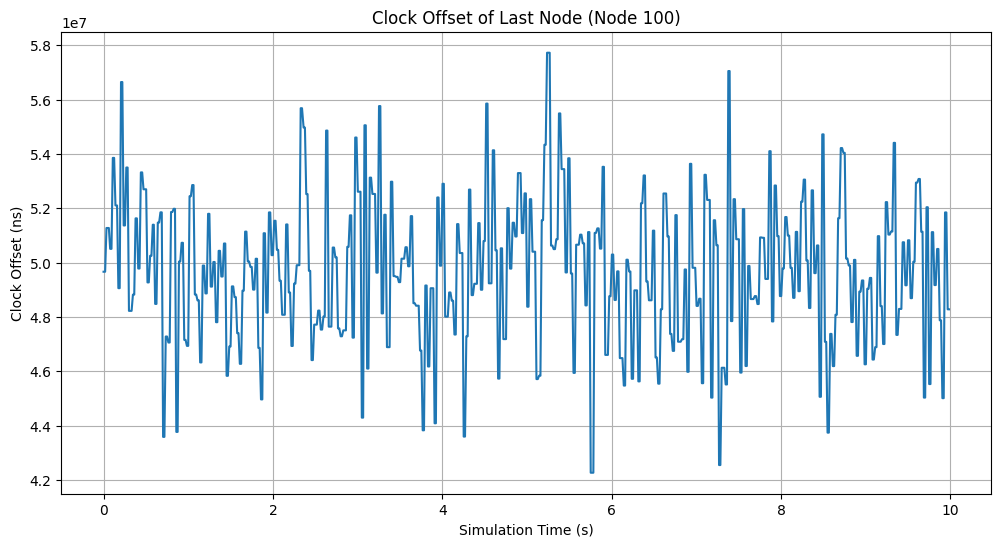

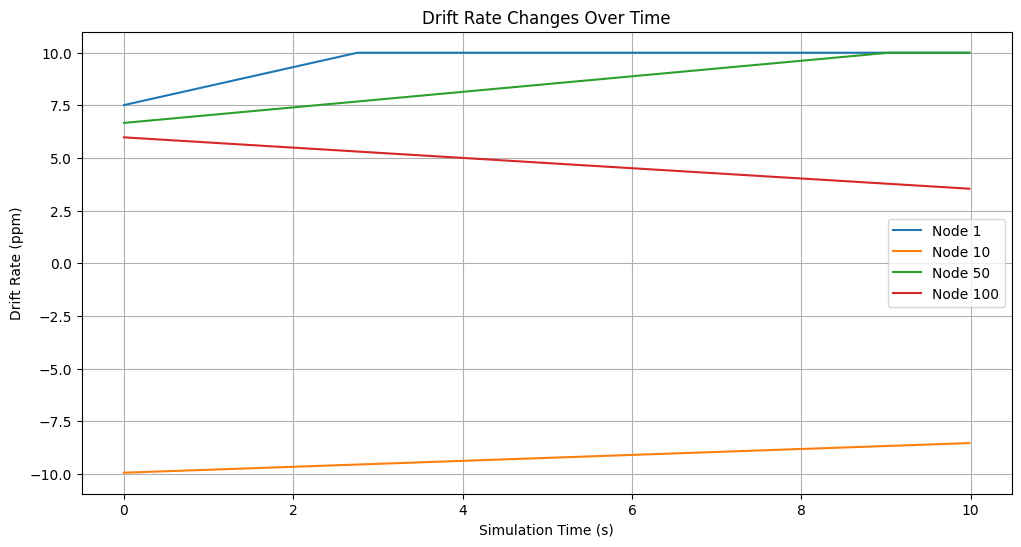

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import pandas as pd

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 10  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
MAX_DRIFT_RATE_CHANGE = 1e-6  # 最大漂移率变化1ppm/s
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

# 创建输出目录
os.makedirs('output_data', exist_ok=True)

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0, drift_rate_change=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.drift_rate_change = 0 if is_ideal else drift_rate_change
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
        self.last_update_time = 0  # 上次更新的仿真时间
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率变化和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 计算此次更新的实际时间间隔
            delta_time = elapsed_sim_time - self.last_update_time
            
            # 更新漂移率（随时间变化）
            if not self.is_ideal and delta_time > 0:
                # 漂移率随时间线性变化
                self.drift_rate += self.drift_rate_change * delta_time
                
                # 限制漂移率不超过最大值
                self.drift_rate = max(min(self.drift_rate, MAX_DRIFT_RATE), -MAX_DRIFT_RATE)
            
            # 带漂移的时钟更新
            real_elapsed = delta_time * (1 + self.drift_rate)
            self.time += real_elapsed
            
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
            
            # 更新上次更新时间
            self.last_update_time = elapsed_sim_time
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0, drift_rate_change=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
        self.clock_times = []  # 记录时钟时间
        self.drift_rates = []  # 记录漂移率
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate, drift_rate_change):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self):
        # 创建节点
        self.nodes = []
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点，每个节点具有独立的漂移率
        for i in range(1, NUM_NODES):
            # 随机生成初始漂移率 (-10ppm to 10ppm)
            drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
            # 随机生成漂移率变化量 (-1ppm/s to 1ppm/s)
            drift_rate_change = np.random.uniform(-MAX_DRIFT_RATE_CHANGE, MAX_DRIFT_RATE_CHANGE)
            
            # 创建节点
            node = Bridge(i, drift_rate, drift_rate_change)
            self.nodes.append(node)
            
            print(f"节点 {i} - 初始漂移率: {drift_rate*1e6:.3f} ppm, 漂移率变化: {drift_rate_change*1e6:.3f} ppm/s")
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录仿真时间点
        self.sim_time_points = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(self.sim_time)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % (SYNC_INTERVAL/2) < time_step:  # 每半个同步周期记录一次数据
                self.sim_time_points.append(self.sim_time)
                gm_time = self.nodes[0].clock.get_time()
                
                for i in range(NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    self.nodes[i].clock_times.append(local_time)
                    
                    # 记录当前漂移率
                    if not self.nodes[i].is_gm:
                        self.nodes[i].drift_rates.append(self.nodes[i].clock.drift_rate)
                    else:
                        self.nodes[i].drift_rates.append(0)
                    
                    if i > 0:  # 非GM节点
                        offset = local_time - gm_time
                        self.nodes[i].clock_offsets.append(offset)
                        
                        # 记录相对于理想时间的真实偏差
                        true_offset = local_time - self.sim_time
                        self.nodes[i].true_offsets.append(true_offset)
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def save_data_to_csv(self):
        """保存数据到CSV文件"""
        # 保存时钟时间
        clock_times_data = {}
        clock_times_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为微秒并保留3位小数
            clock_times_data[f'node_{i}'] = [round(t * 1e6, 3) for t in self.nodes[i].clock_times]
        
        # 创建DataFrame并保存
        df_times = pd.DataFrame(clock_times_data)
        df_times.to_csv('output_data/clock_times.csv', index=False)
        
        # 保存时钟偏差
        offsets_data = {}
        offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].clock_offsets]
        
        # 创建DataFrame并保存
        df_offsets = pd.DataFrame(offsets_data)
        df_offsets.to_csv('output_data/clock_offsets.csv', index=False)
        
        # 保存真实偏差
        true_offsets_data = {}
        true_offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            true_offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].true_offsets]
        
        # 创建DataFrame并保存
        df_true = pd.DataFrame(true_offsets_data)
        df_true.to_csv('output_data/true_offsets.csv', index=False)
        
        # 保存漂移率数据
        drift_rates_data = {}
        drift_rates_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为ppm并保留3位小数
            drift_rates_data[f'node_{i}'] = [round(rate * 1e6, 3) for rate in self.nodes[i].drift_rates]
        
        # 创建DataFrame并保存
        df_drift = pd.DataFrame(drift_rates_data)
        df_drift.to_csv('output_data/drift_rates.csv', index=False)
        
        print("数据已保存到output_data文件夹中")
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for t_idx, offset in enumerate(self.nodes[i].clock_offsets) 
                             if self.sim_time_points[t_idx] > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        # 保存同步精度结果
        precision_data = {
            'node_id': list(range(1, NUM_NODES)),
            'max_offset_us': [round(o * 1e6, 3) for o in max_offsets],  # 转换为微秒并保留3位小数
            'avg_offset_us': [round(o * 1e6, 3) for o in avg_offsets]   # 转换为微秒并保留3位小数
        }
        
        df_precision = pd.DataFrame(precision_data)
        df_precision.to_csv('output_data/sync_precision.csv', index=False)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制时钟偏差
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = self.sim_time_points
            offsets = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
            plt.plot(times, offsets, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Clock Offsets Relative to GM")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/clock_offsets.png', dpi=300)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in max_offsets], 'r-', label="Max Offset")
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in avg_offsets], 'b-', label="Average Offset")
        plt.xlabel("Node ID (Hop Count)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Synchronization Precision vs. Hop Count")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/sync_precision.png', dpi=300)
        
        # 绘制最后一个节点的偏差随时间的变化
        plt.figure(figsize=(12, 6))
        times = self.sim_time_points
        offsets = [o*1e9 for o in self.nodes[-1].clock_offsets]  # 转换为纳秒
        plt.plot(times, offsets)
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Clock Offset (ns)")
        plt.title(f"Clock Offset of Last Node (Node {NUM_NODES-1})")
        plt.grid(True)
        plt.savefig('output_image/last_node_offset.png', dpi=300)
        
        # 绘制几个代表节点的漂移率变化
        plt.figure(figsize=(12, 6))
        for i in nodes_to_plot:
            times = self.sim_time_points
            drift_rates = [rate*1e6 for rate in self.nodes[i].drift_rates]  # 转换为ppm
            plt.plot(times, drift_rates, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Drift Rate (ppm)")
        plt.title("Drift Rate Changes Over Time")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/drift_rates.png', dpi=300)
        
        plt.show()

# 运行仿真
sim = Simulator()
sim.run()
sim.save_data_to_csv()
sim.plot_results()

除了GM意外所有节点的初始漂移率是-10,10之间的数值，不是他们的最大最小值是-10,10ppm。另外，除了漂移率的图之外，还要画TE的折线图。 --thinking_budget 16384

主要修改和补充内容：

确认漂移率设置：

维持了当前的漂移率设置，对每个非GM节点随机生成-10至10 ppm的初始漂移率
对每个节点随机生成-1至1 ppm/s的漂移率变化率
添加TE(时间误差)的折线图：

添加了专门的TE折线图，展示几个代表性节点的时间误差随时间变化
TE实际上就是相对于GM的时钟偏差，我们已经在之前的代码中收集了这些数据
增加TE热图：

添加了一个热图展示，可以同时显示所有节点的TE随时间的变化情况
使用颜色深浅代表TE的正负和大小
文件命名更新：

将时钟偏差的CSV文件名从'clock_offsets.csv'更改为'time_errors.csv'，更准确地反映数据含义
图例和标题更新：

更新了相关图表的标题，使其准确描述TE时间误差
保持了所有图表中的英文标签

节点 1 - 初始漂移率: -8.471 ppm, 漂移率变化: 0.610 ppm/s
节点 2 - 初始漂移率: -8.158 ppm, 漂移率变化: -0.330 ppm/s
节点 3 - 初始漂移率: -8.754 ppm, 漂移率变化: -0.315 ppm/s
节点 4 - 初始漂移率: 7.416 ppm, 漂移率变化: 0.865 ppm/s
节点 5 - 初始漂移率: 4.769 ppm, 漂移率变化: 0.805 ppm/s
节点 6 - 初始漂移率: 7.128 ppm, 漂移率变化: 0.586 ppm/s
节点 7 - 初始漂移率: -2.427 ppm, 漂移率变化: 0.135 ppm/s
节点 8 - 初始漂移率: 8.636 ppm, 漂移率变化: 0.885 ppm/s
节点 9 - 初始漂移率: -2.373 ppm, 漂移率变化: 0.226 ppm/s
节点 10 - 初始漂移率: -0.486 ppm, 漂移率变化: -0.304 ppm/s
节点 11 - 初始漂移率: 9.749 ppm, 漂移率变化: 0.441 ppm/s
节点 12 - 初始漂移率: 1.053 ppm, 漂移率变化: -0.661 ppm/s
节点 13 - 初始漂移率: -4.978 ppm, 漂移率变化: -0.226 ppm/s
节点 14 - 初始漂移率: -5.197 ppm, 漂移率变化: -0.801 ppm/s
节点 15 - 初始漂移率: -0.633 ppm, 漂移率变化: -0.341 ppm/s
节点 16 - 初始漂移率: -5.230 ppm, 漂移率变化: -0.196 ppm/s
节点 17 - 初始漂移率: 4.199 ppm, 漂移率变化: -0.207 ppm/s
节点 18 - 初始漂移率: 4.529 ppm, 漂移率变化: -0.554 ppm/s
节点 19 - 初始漂移率: 0.562 ppm, 漂移率变化: -0.705 ppm/s
节点 20 - 初始漂移率: -9.685 ppm, 漂移率变化: 0.753 ppm/s
节点 21 - 初始漂移率: -4.388 ppm, 漂移率变化: 0.849 ppm/s
节点 22 - 初始漂移率: 6.874 ppm, 漂移率变化: 0.276 pp

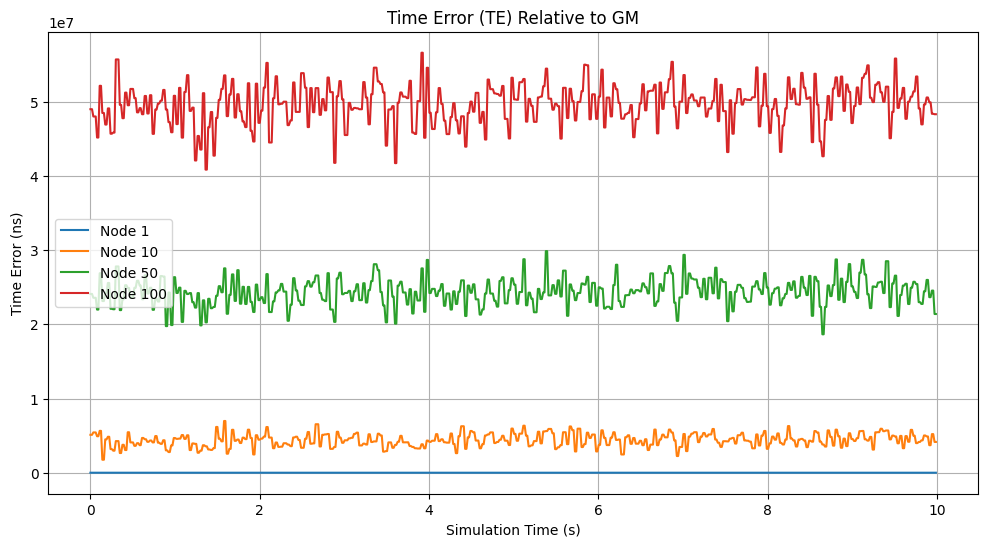

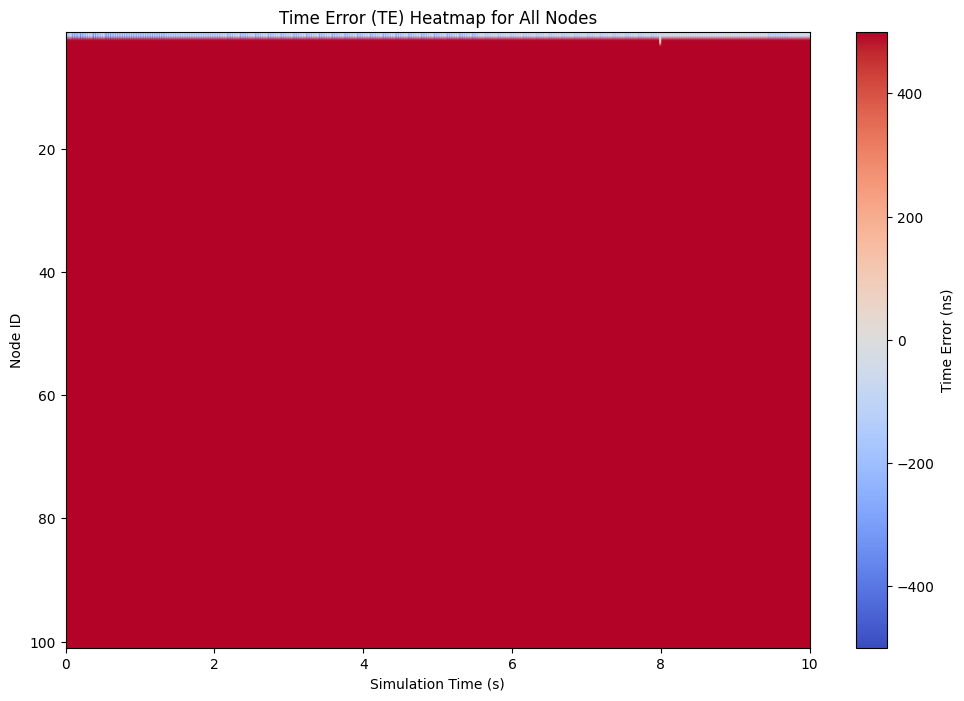

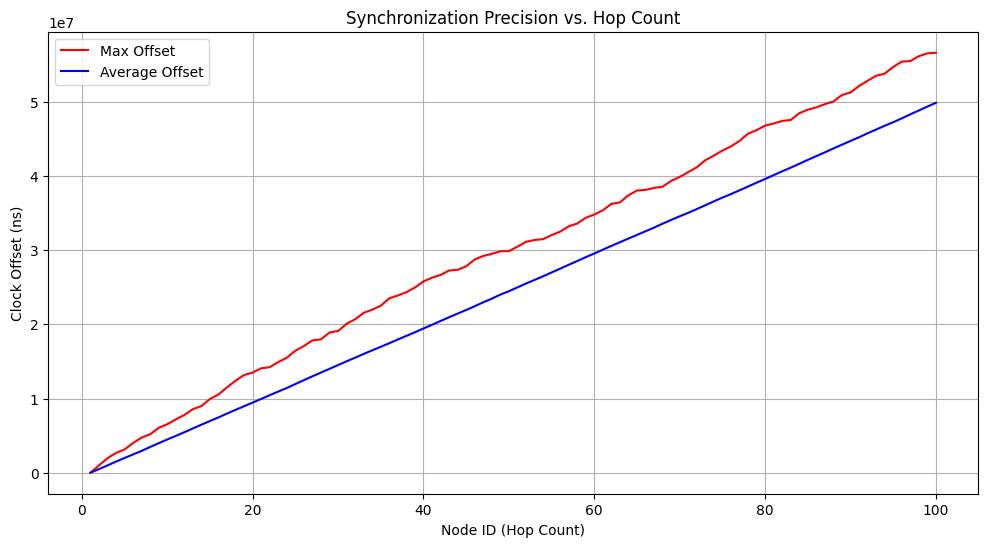

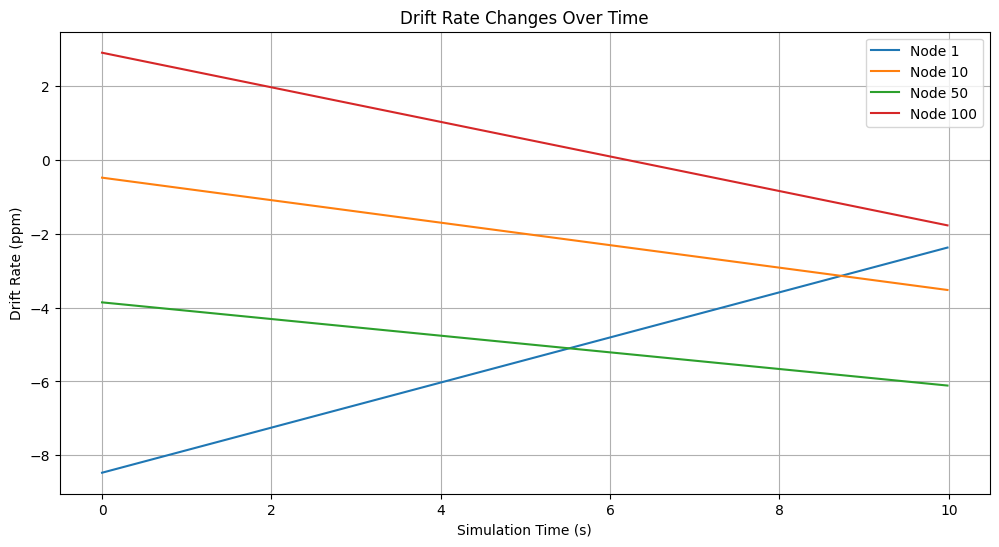

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import pandas as pd

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 10  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
MAX_DRIFT_RATE_CHANGE = 1e-6  # 最大漂移率变化1ppm/s
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

# 创建输出目录
os.makedirs('output_data', exist_ok=True)

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0, drift_rate_change=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.drift_rate_change = 0 if is_ideal else drift_rate_change
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
        self.last_update_time = 0  # 上次更新的仿真时间
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率变化和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 计算此次更新的实际时间间隔
            delta_time = elapsed_sim_time - self.last_update_time
            
            # 更新漂移率（随时间变化）
            if not self.is_ideal and delta_time > 0:
                # 漂移率随时间线性变化
                self.drift_rate += self.drift_rate_change * delta_time
                
                # 限制漂移率不超过最大值
                self.drift_rate = max(min(self.drift_rate, MAX_DRIFT_RATE), -MAX_DRIFT_RATE)
            
            # 带漂移的时钟更新
            real_elapsed = delta_time * (1 + self.drift_rate)
            self.time += real_elapsed
            
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
            
            # 更新上次更新时间
            self.last_update_time = elapsed_sim_time
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0, drift_rate_change=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
        self.clock_times = []  # 记录时钟时间
        self.drift_rates = []  # 记录漂移率
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate, drift_rate_change):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self):
        # 创建节点
        self.nodes = []
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点，每个节点具有独立的漂移率
        for i in range(1, NUM_NODES):
            # 随机生成初始漂移率 (-10ppm to 10ppm)
            drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
            # 随机生成漂移率变化量 (-1ppm/s to 1ppm/s)
            drift_rate_change = np.random.uniform(-MAX_DRIFT_RATE_CHANGE, MAX_DRIFT_RATE_CHANGE)
            
            # 创建节点
            node = Bridge(i, drift_rate, drift_rate_change)
            self.nodes.append(node)
            
            print(f"节点 {i} - 初始漂移率: {drift_rate*1e6:.3f} ppm, 漂移率变化: {drift_rate_change*1e6:.3f} ppm/s")
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录仿真时间点
        self.sim_time_points = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(self.sim_time)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % (SYNC_INTERVAL/2) < time_step:  # 每半个同步周期记录一次数据
                self.sim_time_points.append(self.sim_time)
                gm_time = self.nodes[0].clock.get_time()
                
                for i in range(NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    self.nodes[i].clock_times.append(local_time)
                    
                    # 记录当前漂移率
                    if not self.nodes[i].is_gm:
                        self.nodes[i].drift_rates.append(self.nodes[i].clock.drift_rate)
                    else:
                        self.nodes[i].drift_rates.append(0)
                    
                    if i > 0:  # 非GM节点
                        offset = local_time - gm_time
                        self.nodes[i].clock_offsets.append(offset)
                        
                        # 记录相对于理想时间的真实偏差
                        true_offset = local_time - self.sim_time
                        self.nodes[i].true_offsets.append(true_offset)
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def save_data_to_csv(self):
        """保存数据到CSV文件"""
        # 保存时钟时间
        clock_times_data = {}
        clock_times_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为微秒并保留3位小数
            clock_times_data[f'node_{i}'] = [round(t * 1e6, 3) for t in self.nodes[i].clock_times]
        
        # 创建DataFrame并保存
        df_times = pd.DataFrame(clock_times_data)
        df_times.to_csv('output_data/clock_times.csv', index=False)
        
        # 保存时钟偏差 (TE - Time Error)
        offsets_data = {}
        offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].clock_offsets]
        
        # 创建DataFrame并保存
        df_offsets = pd.DataFrame(offsets_data)
        df_offsets.to_csv('output_data/time_errors.csv', index=False)
        
        # 保存真实偏差
        true_offsets_data = {}
        true_offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            true_offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].true_offsets]
        
        # 创建DataFrame并保存
        df_true = pd.DataFrame(true_offsets_data)
        df_true.to_csv('output_data/true_offsets.csv', index=False)
        
        # 保存漂移率数据
        drift_rates_data = {}
        drift_rates_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为ppm并保留3位小数
            drift_rates_data[f'node_{i}'] = [round(rate * 1e6, 3) for rate in self.nodes[i].drift_rates]
        
        # 创建DataFrame并保存
        df_drift = pd.DataFrame(drift_rates_data)
        df_drift.to_csv('output_data/drift_rates.csv', index=False)
        
        print("数据已保存到output_data文件夹中")
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for t_idx, offset in enumerate(self.nodes[i].clock_offsets) 
                             if self.sim_time_points[t_idx] > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        # 保存同步精度结果
        precision_data = {
            'node_id': list(range(1, NUM_NODES)),
            'max_offset_us': [round(o * 1e6, 3) for o in max_offsets],  # 转换为微秒并保留3位小数
            'avg_offset_us': [round(o * 1e6, 3) for o in avg_offsets]   # 转换为微秒并保留3位小数
        }
        
        df_precision = pd.DataFrame(precision_data)
        df_precision.to_csv('output_data/sync_precision.csv', index=False)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制TE(时间误差)折线图 - 选择几个代表性节点
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = self.sim_time_points
            offsets = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
            plt.plot(times, offsets, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Time Error (ns)")
        plt.title("Time Error (TE) Relative to GM")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/time_errors.png', dpi=300)
        
        # 绘制所有节点的TE热图
        plt.figure(figsize=(12, 8))
        
        te_data = np.zeros((NUM_NODES-1, len(self.sim_time_points)))
        for i in range(1, NUM_NODES):
            te_data[i-1, :] = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
        
        im = plt.imshow(te_data, aspect='auto', cmap='coolwarm', 
                       extent=[0, SIMULATION_TIME, NUM_NODES, 1], 
                       vmin=-500, vmax=500)  # 限制色标范围以提高对比度
        
        plt.colorbar(im, label="Time Error (ns)")
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Node ID")
        plt.title("Time Error (TE) Heatmap for All Nodes")
        plt.savefig('output_data/time_error_heatmap.png', dpi=300)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in max_offsets], 'r-', label="Max Offset")
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in avg_offsets], 'b-', label="Average Offset")
        plt.xlabel("Node ID (Hop Count)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Synchronization Precision vs. Hop Count")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/sync_precision.png', dpi=300)
        
        # 绘制几个代表节点的漂移率变化
        plt.figure(figsize=(12, 6))
        for i in nodes_to_plot:
            times = self.sim_time_points
            drift_rates = [rate*1e6 for rate in self.nodes[i].drift_rates]  # 转换为ppm
            plt.plot(times, drift_rates, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Drift Rate (ppm)")
        plt.title("Drift Rate Changes Over Time")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/drift_rates.png', dpi=300)
        
        plt.show()

# 运行仿真
sim = Simulator()
sim.run()
sim.save_data_to_csv()
sim.plot_results()

节点 1 - 初始漂移率: -6.132 ppm
节点 2 - 初始漂移率: 2.716 ppm
节点 3 - 初始漂移率: -3.658 ppm
节点 4 - 初始漂移率: 4.528 ppm
节点 5 - 初始漂移率: 8.924 ppm
节点 6 - 初始漂移率: -6.388 ppm
节点 7 - 初始漂移率: 1.121 ppm
节点 8 - 初始漂移率: -9.564 ppm
节点 9 - 初始漂移率: 1.758 ppm
节点 10 - 初始漂移率: 5.312 ppm
节点 11 - 初始漂移率: -4.664 ppm
节点 12 - 初始漂移率: -8.100 ppm
节点 13 - 初始漂移率: -1.550 ppm
节点 14 - 初始漂移率: -1.853 ppm
节点 15 - 初始漂移率: -5.687 ppm
节点 16 - 初始漂移率: -2.722 ppm
节点 17 - 初始漂移率: 2.001 ppm
节点 18 - 初始漂移率: 7.801 ppm
节点 19 - 初始漂移率: -0.253 ppm
节点 20 - 初始漂移率: 3.247 ppm
节点 21 - 初始漂移率: 0.590 ppm
节点 22 - 初始漂移率: 8.320 ppm
节点 23 - 初始漂移率: 0.844 ppm
节点 24 - 初始漂移率: 9.590 ppm
节点 25 - 初始漂移率: 0.334 ppm
节点 26 - 初始漂移率: 6.164 ppm
节点 27 - 初始漂移率: -9.104 ppm
节点 28 - 初始漂移率: 4.193 ppm
节点 29 - 初始漂移率: 9.691 ppm
节点 30 - 初始漂移率: -1.324 ppm
节点 31 - 初始漂移率: 1.774 ppm
节点 32 - 初始漂移率: 5.609 ppm
节点 33 - 初始漂移率: 7.045 ppm
节点 34 - 初始漂移率: -1.477 ppm
节点 35 - 初始漂移率: 1.546 ppm
节点 36 - 初始漂移率: -7.605 ppm
节点 37 - 初始漂移率: 8.188 ppm
节点 38 - 初始漂移率: -4.207 ppm
节点 39 - 初始漂移率: 3.154 ppm
节点 40 - 初始漂移率: -6.

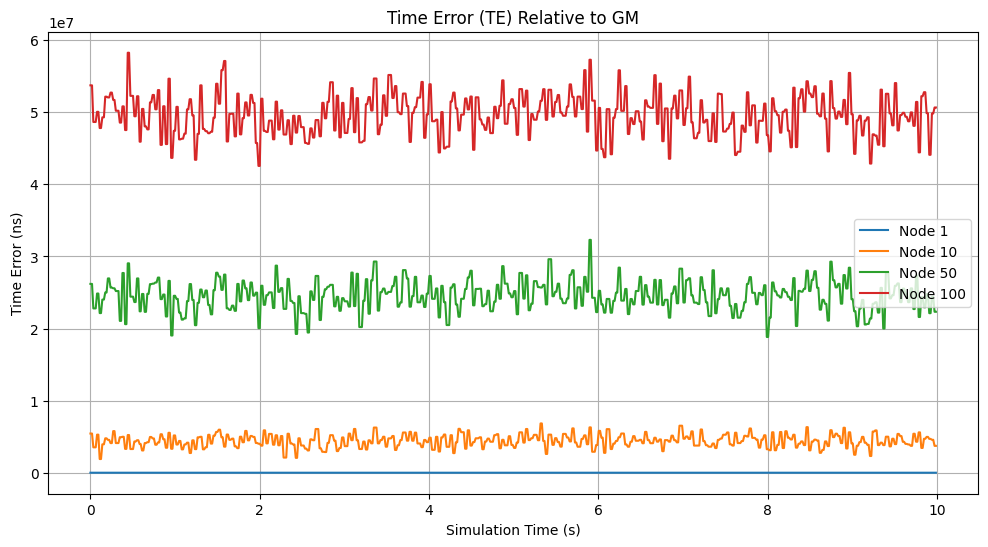

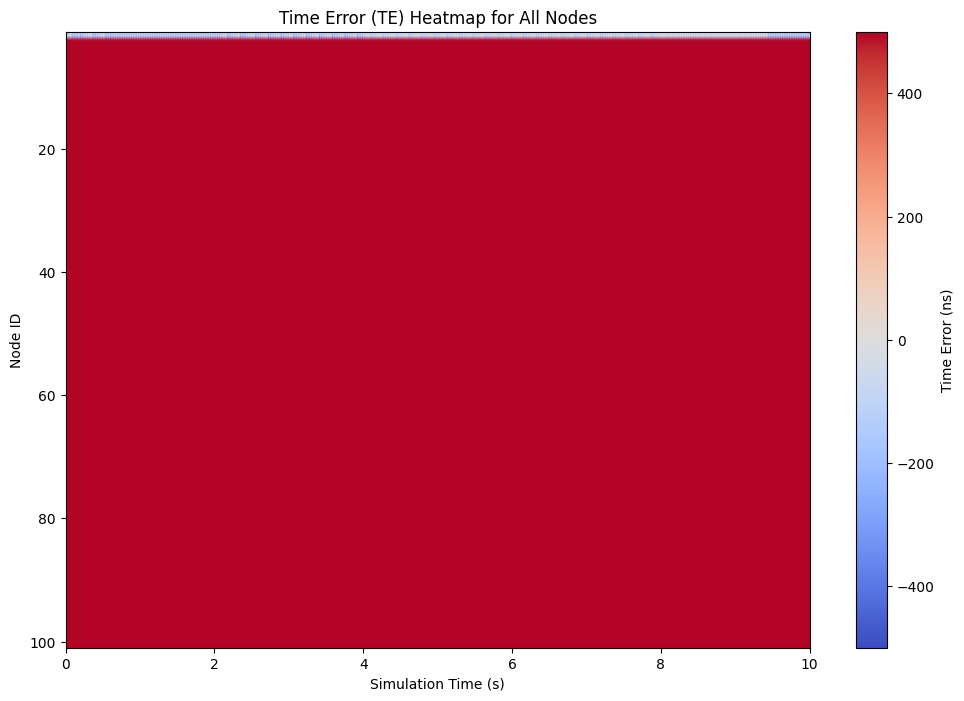

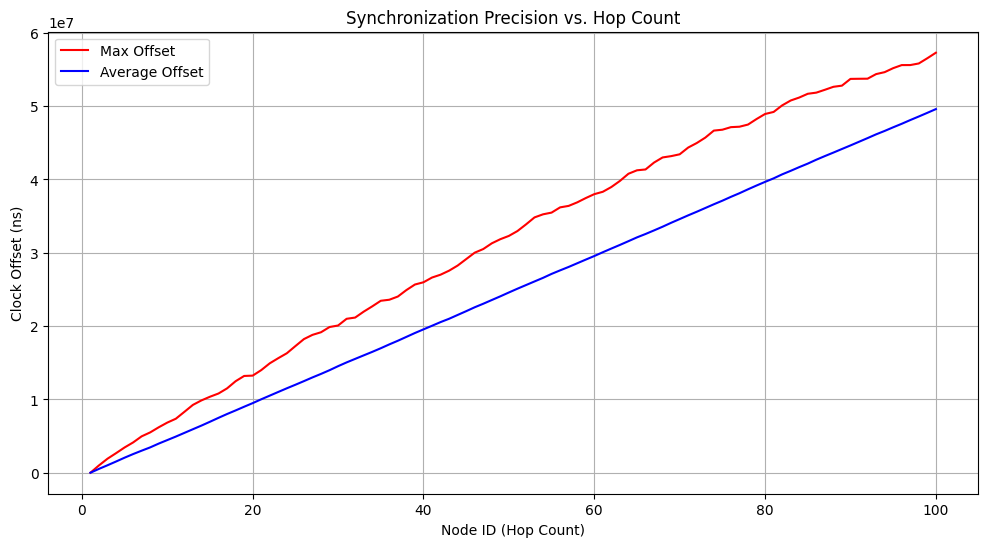

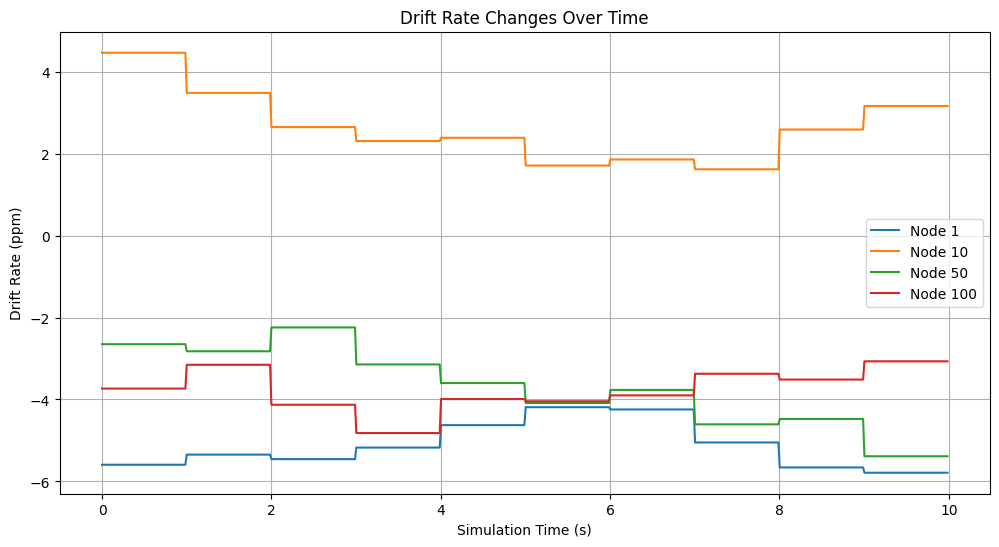

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import pandas as pd

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 10  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
MAX_DRIFT_RATE_CHANGE = 1e-6  # 最大漂移率变化1ppm/s
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

# 创建输出目录
os.makedirs('output_data', exist_ok=True)

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0, drift_rate_change=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.drift_rate_change = 0 if is_ideal else drift_rate_change
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
        self.last_update_time = 0  # 上次更新的仿真时间
        self.last_drift_update_second = -1  # 上次更新漂移率的整数秒
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率变化和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 检查是否过了一个新的整数秒
            current_second = int(elapsed_sim_time)
            if current_second > self.last_drift_update_second:
                # 每秒更新一次漂移率
                drift_change = np.random.uniform(-MAX_DRIFT_RATE_CHANGE, MAX_DRIFT_RATE_CHANGE)
                self.drift_rate += drift_change
                
                # 限制漂移率不超过最大值
                self.drift_rate = max(min(self.drift_rate, MAX_DRIFT_RATE), -MAX_DRIFT_RATE)
                
                # 更新上次漂移率更新时间
                self.last_drift_update_second = current_second
                
            # 计算此次更新的实际时间间隔
            delta_time = elapsed_sim_time - self.last_update_time
            
            # 带漂移的时钟更新
            real_elapsed = delta_time * (1 + self.drift_rate)
            self.time += real_elapsed
            
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
            
            # 更新上次更新时间
            self.last_update_time = elapsed_sim_time
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0, drift_rate_change=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
        self.clock_times = []  # 记录时钟时间
        self.drift_rates = []  # 记录漂移率
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate, drift_rate_change=0):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self):
        # 创建节点
        self.nodes = []
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点，每个节点具有独立的漂移率
        for i in range(1, NUM_NODES):
            # 随机生成初始漂移率 (-10ppm to 10ppm)
            drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
            # drift_rate_change参数不再使用，因为我们在Clock类中每秒更新漂移率
            # 使用0作为占位符
            node = Bridge(i, drift_rate, 0)
            self.nodes.append(node)
            
            print(f"节点 {i} - 初始漂移率: {drift_rate*1e6:.3f} ppm")
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录仿真时间点
        self.sim_time_points = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(self.sim_time)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % (SYNC_INTERVAL/2) < time_step:  # 每半个同步周期记录一次数据
                self.sim_time_points.append(self.sim_time)
                gm_time = self.nodes[0].clock.get_time()
                
                for i in range(NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    self.nodes[i].clock_times.append(local_time)
                    
                    # 记录当前漂移率
                    if not self.nodes[i].is_gm:
                        self.nodes[i].drift_rates.append(self.nodes[i].clock.drift_rate)
                    else:
                        self.nodes[i].drift_rates.append(0)
                    
                    if i > 0:  # 非GM节点
                        offset = local_time - gm_time
                        self.nodes[i].clock_offsets.append(offset)
                        
                        # 记录相对于理想时间的真实偏差
                        true_offset = local_time - self.sim_time
                        self.nodes[i].true_offsets.append(true_offset)
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def save_data_to_csv(self):
        """保存数据到CSV文件"""
        # 保存时钟时间
        clock_times_data = {}
        clock_times_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为微秒并保留3位小数
            clock_times_data[f'node_{i}'] = [round(t * 1e6, 3) for t in self.nodes[i].clock_times]
        
        # 创建DataFrame并保存
        df_times = pd.DataFrame(clock_times_data)
        df_times.to_csv('output_data/clock_times.csv', index=False)
        
        # 保存时钟偏差 (TE - Time Error)
        offsets_data = {}
        offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].clock_offsets]
        
        # 创建DataFrame并保存
        df_offsets = pd.DataFrame(offsets_data)
        df_offsets.to_csv('output_data/time_errors.csv', index=False)
        
        # 保存真实偏差
        true_offsets_data = {}
        true_offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            true_offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].true_offsets]
        
        # 创建DataFrame并保存
        df_true = pd.DataFrame(true_offsets_data)
        df_true.to_csv('output_data/true_offsets.csv', index=False)
        
        # 保存漂移率数据
        drift_rates_data = {}
        drift_rates_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为ppm并保留3位小数
            drift_rates_data[f'node_{i}'] = [round(rate * 1e6, 3) for rate in self.nodes[i].drift_rates]
        
        # 创建DataFrame并保存
        df_drift = pd.DataFrame(drift_rates_data)
        df_drift.to_csv('output_data/drift_rates.csv', index=False)
        
        print("数据已保存到output_data文件夹中")
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for t_idx, offset in enumerate(self.nodes[i].clock_offsets) 
                             if self.sim_time_points[t_idx] > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        # 保存同步精度结果
        precision_data = {
            'node_id': list(range(1, NUM_NODES)),
            'max_offset_us': [round(o * 1e6, 3) for o in max_offsets],  # 转换为微秒并保留3位小数
            'avg_offset_us': [round(o * 1e6, 3) for o in avg_offsets]   # 转换为微秒并保留3位小数
        }
        
        df_precision = pd.DataFrame(precision_data)
        df_precision.to_csv('output_data/sync_precision.csv', index=False)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制TE(时间误差)折线图 - 选择几个代表性节点
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = self.sim_time_points
            offsets = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
            plt.plot(times, offsets, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Time Error (ns)")
        plt.title("Time Error (TE) Relative to GM")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/time_errors.png', dpi=300)
        
        # 绘制所有节点的TE热图
        plt.figure(figsize=(12, 8))
        
        te_data = np.zeros((NUM_NODES-1, len(self.sim_time_points)))
        for i in range(1, NUM_NODES):
            te_data[i-1, :] = [o*1e9 for o in self.nodes[i].clock_offsets]  # 转换为纳秒
        
        im = plt.imshow(te_data, aspect='auto', cmap='coolwarm', 
                       extent=[0, SIMULATION_TIME, NUM_NODES, 1], 
                       vmin=-500, vmax=500)  # 限制色标范围以提高对比度
        
        plt.colorbar(im, label="Time Error (ns)")
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Node ID")
        plt.title("Time Error (TE) Heatmap for All Nodes")
        plt.savefig('output_data/time_error_heatmap.png', dpi=300)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in max_offsets], 'r-', label="Max Offset")
        plt.plot(range(1, NUM_NODES), [o*1e9 for o in avg_offsets], 'b-', label="Average Offset")
        plt.xlabel("Node ID (Hop Count)")
        plt.ylabel("Clock Offset (ns)")
        plt.title("Synchronization Precision vs. Hop Count")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/sync_precision.png', dpi=300)
        
        # 绘制几个代表节点的漂移率变化
        plt.figure(figsize=(12, 6))
        for i in nodes_to_plot:
            times = self.sim_time_points
            drift_rates = [rate*1e6 for rate in self.nodes[i].drift_rates]  # 转换为ppm
            plt.plot(times, drift_rates, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Drift Rate (ppm)")
        plt.title("Drift Rate Changes Over Time")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_data/drift_rates.png', dpi=300)
        
        plt.show()

# 运行仿真
sim = Simulator()
sim.run()
sim.save_data_to_csv()
sim.plot_results()

节点 1 - 初始漂移率: 3.091 ppm
节点 2 - 初始漂移率: 7.736 ppm
节点 3 - 初始漂移率: -9.147 ppm
节点 4 - 初始漂移率: -3.452 ppm
节点 5 - 初始漂移率: -6.570 ppm
节点 6 - 初始漂移率: 2.500 ppm
节点 7 - 初始漂移率: 3.489 ppm
节点 8 - 初始漂移率: 8.584 ppm
节点 9 - 初始漂移率: 6.071 ppm
节点 10 - 初始漂移率: -0.281 ppm
节点 11 - 初始漂移率: -0.608 ppm
节点 12 - 初始漂移率: 3.265 ppm
节点 13 - 初始漂移率: -2.793 ppm
节点 14 - 初始漂移率: -3.014 ppm
节点 15 - 初始漂移率: 5.688 ppm
节点 16 - 初始漂移率: 9.977 ppm
节点 17 - 初始漂移率: 8.932 ppm
节点 18 - 初始漂移率: -0.328 ppm
节点 19 - 初始漂移率: 0.161 ppm
节点 20 - 初始漂移率: 0.601 ppm
节点 21 - 初始漂移率: -0.080 ppm
节点 22 - 初始漂移率: -2.804 ppm
节点 23 - 初始漂移率: -6.738 ppm
节点 24 - 初始漂移率: -0.722 ppm
节点 25 - 初始漂移率: -3.673 ppm
节点 26 - 初始漂移率: 9.753 ppm
节点 27 - 初始漂移率: -3.866 ppm
节点 28 - 初始漂移率: -4.917 ppm
节点 29 - 初始漂移率: -6.959 ppm
节点 30 - 初始漂移率: -3.501 ppm
节点 31 - 初始漂移率: 5.372 ppm
节点 32 - 初始漂移率: 3.329 ppm
节点 33 - 初始漂移率: 6.948 ppm
节点 34 - 初始漂移率: 8.428 ppm
节点 35 - 初始漂移率: -7.738 ppm
节点 36 - 初始漂移率: 4.598 ppm
节点 37 - 初始漂移率: -0.989 ppm
节点 38 - 初始漂移率: 7.821 ppm
节点 39 - 初始漂移率: -3.756 ppm
节点 40 - 初始漂移率:

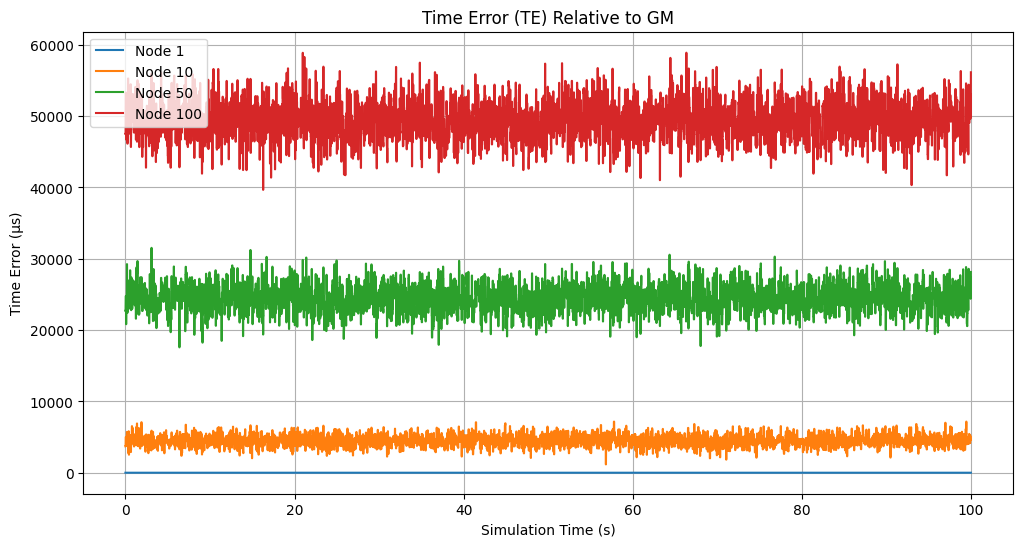

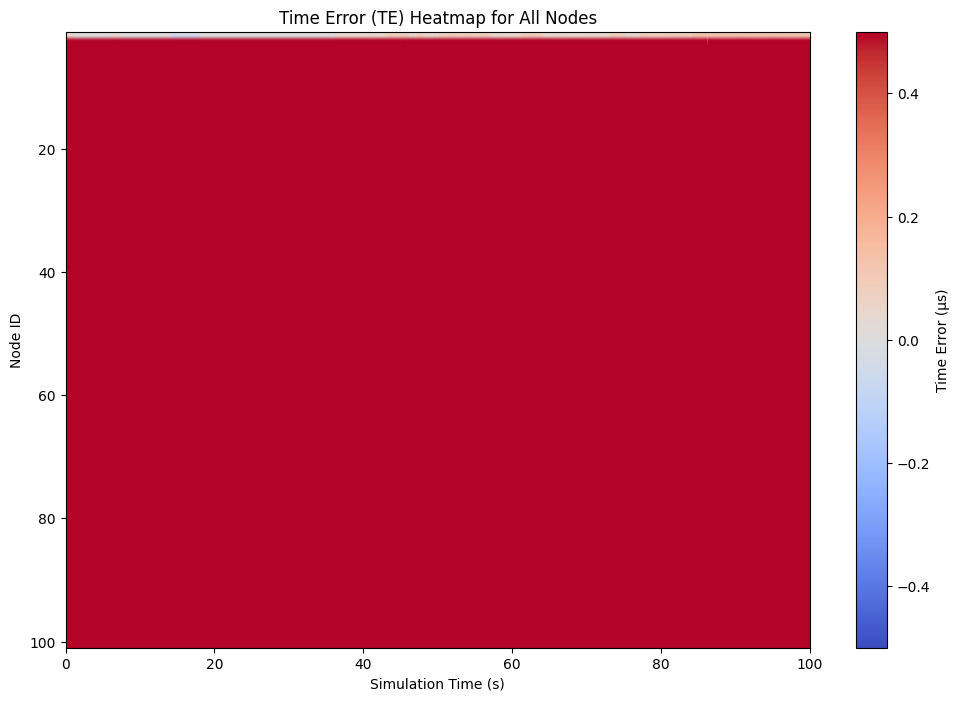

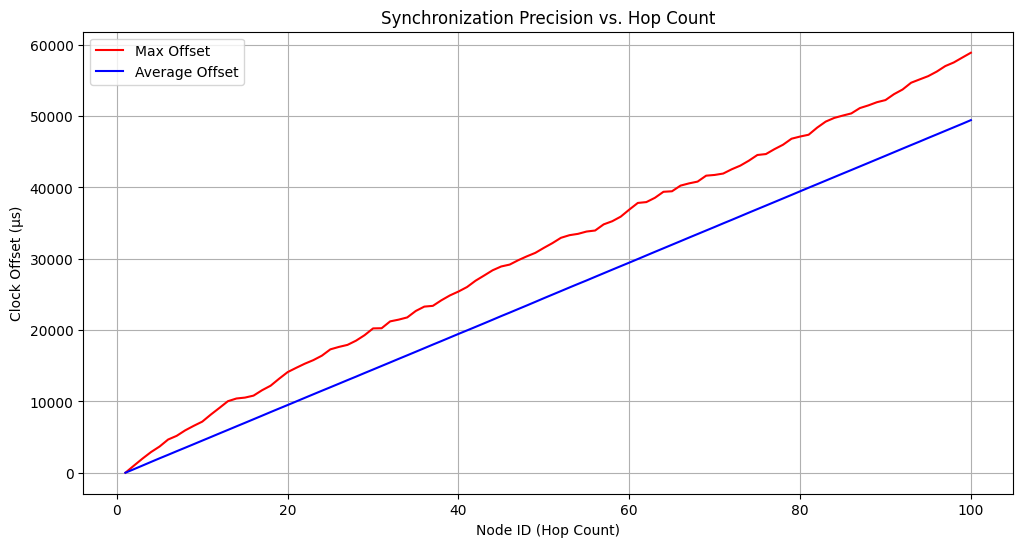

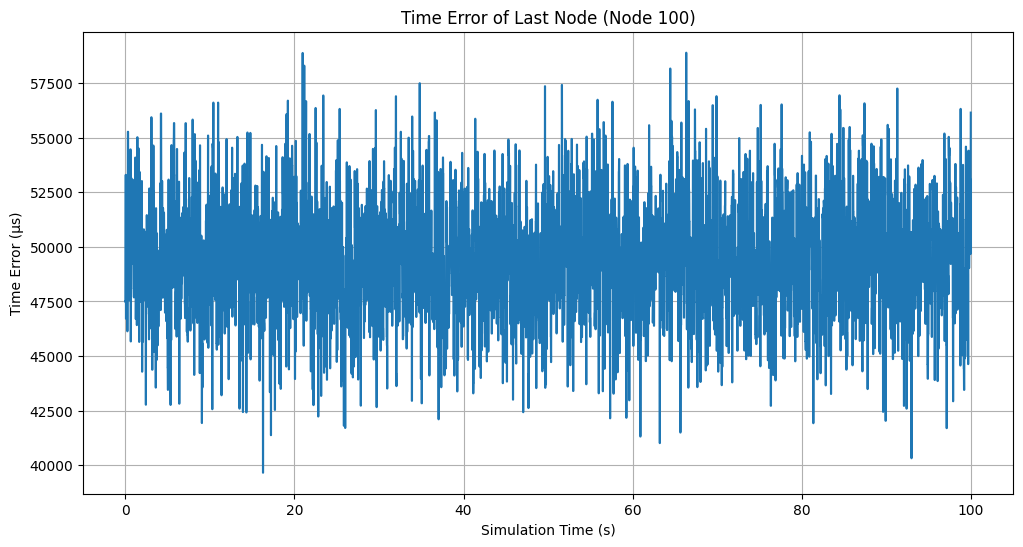

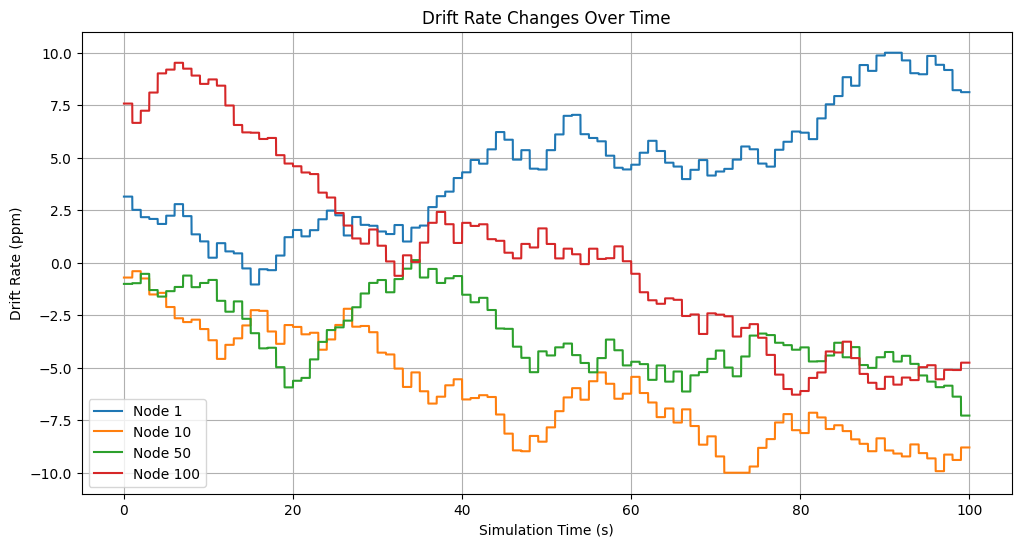

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import os
import csv
import pandas as pd

# 常量定义
NUM_NODES = 101  # 总节点数 (1个GM + 99个桥接器 + 1个终端)
SIMULATION_TIME = 100  # 仿真总时间(秒)
SYNC_INTERVAL = 0.03125  # 同步间隔31.25ms
PDELAY_INTERVAL = 1.0  # 链路延迟测量间隔1s
CLOCK_GRANULARITY = 8e-9  # 时钟粒度8ns
PHY_JITTER_MAX = 8e-9  # 物理层抖动最大值8ns
MAX_DRIFT_RATE = 10e-6  # 最大漂移率10ppm
MAX_DRIFT_RATE_CHANGE = 1e-6  # 最大漂移率变化1ppm/s
LINK_DELAY = 50e-9  # 链路延迟50ns
RESIDENCE_TIME = 1e-3  # 最大驻留时间1ms

# 创建输出目录
os.makedirs('output_data', exist_ok=True)
os.makedirs('output_image', exist_ok=True)  # 创建图片保存目录

class Clock:
    """时钟模型"""
    def __init__(self, is_ideal=False, drift_rate=0, drift_rate_change=0):
        self.is_ideal = is_ideal
        self.drift_rate = 0 if is_ideal else drift_rate
        self.drift_rate_change = 0 if is_ideal else drift_rate_change
        self.time = 0
        self.granularity = CLOCK_GRANULARITY
        self.last_update_time = 0  # 上次更新的仿真时间
        self.last_drift_update_second = -1  # 上次更新漂移率的整数秒
    
    def update(self, elapsed_sim_time):
        """更新时钟，考虑漂移率变化和粒度"""
        if self.is_ideal:
            self.time = elapsed_sim_time
        else:
            # 检查是否过了一个新的整数秒
            current_second = int(elapsed_sim_time)
            if current_second > self.last_drift_update_second:
                # 每秒更新一次漂移率
                drift_change = np.random.uniform(-MAX_DRIFT_RATE_CHANGE, MAX_DRIFT_RATE_CHANGE)
                self.drift_rate += drift_change
                
                # 限制漂移率不超过最大值
                self.drift_rate = max(min(self.drift_rate, MAX_DRIFT_RATE), -MAX_DRIFT_RATE)
                
                # 更新上次漂移率更新时间
                self.last_drift_update_second = current_second
                
            # 计算此次更新的实际时间间隔
            delta_time = elapsed_sim_time - self.last_update_time
            
            # 带漂移的时钟更新
            real_elapsed = delta_time * (1 + self.drift_rate)
            self.time += real_elapsed
            
            # 考虑时钟粒度
            self.time = int(self.time / self.granularity) * self.granularity
            
            # 更新上次更新时间
            self.last_update_time = elapsed_sim_time
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust(self, offset):
        """调整时钟偏移"""
        if not self.is_ideal:
            self.time += offset

class TimeAwareNode:
    """时间感知节点基类"""
    def __init__(self, node_id, is_gm=False, drift_rate=0, drift_rate_change=0):
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock(is_ideal=is_gm, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
        
        # 链路延迟测量
        self.measured_link_delay = LINK_DELAY  # 初始假设的链路延迟
        self.neighbor_rate_ratio = 1.0
        
        # 同步状态
        self.last_sync_receive_time = 0
        self.last_sync_send_time = 0
        self.correction_field = 0
        self.rate_ratio = 1.0
        
        # 统计数据
        self.clock_offsets = []
        self.true_offsets = []
        self.clock_times = []  # 记录时钟时间
        self.drift_rates = []  # 记录漂移率
    
    def process_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """处理同步消息和后续Follow_Up消息的信息"""
        self.last_sync_receive_time = self.clock.get_time()
        
        # 计算时钟偏移并调整
        offset = origin_timestamp + correction_field - self.last_sync_receive_time
        self.clock.adjust(offset)
        
        # 更新本地状态
        self.correction_field = correction_field
        self.rate_ratio = rate_ratio
        
        # 返回接收时间(本地时钟)
        return self.last_sync_receive_time
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息(仅桥节点需要实现)"""
        pass
    
    def measure_link_delay(self, sim_time):
        """模拟对等延迟测量过程"""
        # 简化模型：添加随机误差的链路延迟测量
        jitter1 = np.random.uniform(0, PHY_JITTER_MAX)
        jitter2 = np.random.uniform(0, PHY_JITTER_MAX)
        measured_delay = LINK_DELAY + jitter1 + jitter2 + CLOCK_GRANULARITY
        
        # 模拟对等延迟测量的随机误差
        error = np.random.normal(0, 3e-9)  # 3ns标准差
        self.measured_link_delay = measured_delay + error
        
        # 返回测量的链路延迟
        return self.measured_link_delay

class Grandmaster(TimeAwareNode):
    """GM节点模型"""
    def __init__(self, node_id):
        super().__init__(node_id, is_gm=True)
    
    def generate_sync_message(self, sim_time):
        """生成同步消息"""
        # 获取精确发送时间戳
        precise_origin_timestamp = self.clock.get_time()
        return precise_origin_timestamp, 0, 1.0  # 原始时间戳，修正域为0，速率比率为1

class Bridge(TimeAwareNode):
    """桥节点(交换机)模型"""
    def __init__(self, node_id, drift_rate, drift_rate_change=0):
        super().__init__(node_id, is_gm=False, drift_rate=drift_rate, drift_rate_change=drift_rate_change)
    
    def forward_sync_message(self, origin_timestamp, correction_field, rate_ratio, sim_time):
        """转发同步消息"""
        # 计算驻留时间(随机化，最大为RESIDENCE_TIME)
        residence_time = np.random.uniform(0, RESIDENCE_TIME)
        
        # 更新修正域
        new_correction = correction_field + self.measured_link_delay + (residence_time * rate_ratio)
        
        # 更新速率比率 (假设邻居速率比率测量有±0.1ppm误差)
        neighbor_rate_error = np.random.uniform(-0.1e-6, 0.1e-6)
        self.neighbor_rate_ratio = (1 + self.clock.drift_rate) / (1 + (self.clock.drift_rate - neighbor_rate_error))
        new_rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # 更新发送时间
        self.last_sync_send_time = self.clock.get_time() + residence_time
        
        return origin_timestamp, new_correction, new_rate_ratio

class Simulator:
    """仿真器类"""
    def __init__(self):
        # 创建节点
        self.nodes = []
        
        # 创建GM节点
        self.nodes.append(Grandmaster(0))
        
        # 创建桥节点和终端节点，每个节点具有独立的漂移率
        for i in range(1, NUM_NODES):
            # 随机生成初始漂移率 (-10ppm to 10ppm)
            drift_rate = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
            
            # drift_rate_change参数不再使用，因为我们在Clock类中每秒更新漂移率
            # 使用0作为占位符
            node = Bridge(i, drift_rate, 0)
            self.nodes.append(node)
            
            print(f"节点 {i} - 初始漂移率: {drift_rate*1e6:.3f} ppm")
        
        # 仿真时间
        self.sim_time = 0
        
        # 记录仿真时间点
        self.sim_time_points = []
    
    def run(self):
        """运行仿真"""
        # 时间步进仿真
        time_step = min(SYNC_INTERVAL, PDELAY_INTERVAL) / 10  # 选择一个合适的时间步长
        
        next_sync_time = 0
        next_pdelay_time = 0
        
        while self.sim_time < SIMULATION_TIME:
            # 更新所有节点的时钟
            for node in self.nodes:
                node.clock.update(self.sim_time)
            
            # 处理同步消息
            if self.sim_time >= next_sync_time:
                # GM生成同步消息
                origin_timestamp, correction, rate_ratio = self.nodes[0].generate_sync_message(self.sim_time)
                
                # 逐跳传递同步消息
                for i in range(1, NUM_NODES):
                    # 添加物理层抖动
                    jitter = np.random.uniform(0, PHY_JITTER_MAX)
                    
                    # 处理同步消息
                    self.nodes[i].process_sync_message(origin_timestamp, correction, rate_ratio, self.sim_time)
                    
                    # 如果不是最后一个节点，则继续转发
                    if i < NUM_NODES - 1:
                        origin_timestamp, correction, rate_ratio = self.nodes[i].forward_sync_message(
                            origin_timestamp, correction, rate_ratio, self.sim_time)
                
                next_sync_time = self.sim_time + SYNC_INTERVAL
            
            # 处理链路延迟测量
            if self.sim_time >= next_pdelay_time:
                for i in range(1, NUM_NODES):
                    self.nodes[i].measure_link_delay(self.sim_time)
                next_pdelay_time = self.sim_time + PDELAY_INTERVAL
            
            # 记录统计数据
            if self.sim_time % (SYNC_INTERVAL/2) < time_step:  # 每半个同步周期记录一次数据
                self.sim_time_points.append(self.sim_time)
                gm_time = self.nodes[0].clock.get_time()
                
                for i in range(NUM_NODES):
                    local_time = self.nodes[i].clock.get_time()
                    self.nodes[i].clock_times.append(local_time)
                    
                    # 记录当前漂移率
                    if not self.nodes[i].is_gm:
                        self.nodes[i].drift_rates.append(self.nodes[i].clock.drift_rate)
                    else:
                        self.nodes[i].drift_rates.append(0)
                    
                    if i > 0:  # 非GM节点
                        offset = local_time - gm_time
                        self.nodes[i].clock_offsets.append(offset)
                        
                        # 记录相对于理想时间的真实偏差
                        true_offset = local_time - self.sim_time
                        self.nodes[i].true_offsets.append(true_offset)
            
            # 推进仿真时间
            self.sim_time += time_step
    
    def save_data_to_csv(self):
        """保存数据到CSV文件"""
        # 保存时钟时间
        clock_times_data = {}
        clock_times_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为微秒并保留3位小数
            clock_times_data[f'node_{i}'] = [round(t * 1e6, 3) for t in self.nodes[i].clock_times]
        
        # 创建DataFrame并保存
        df_times = pd.DataFrame(clock_times_data)
        df_times.to_csv('output_data/clock_times.csv', index=False)
        
        # 保存时钟偏差 (TE - Time Error)
        offsets_data = {}
        offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].clock_offsets]
        
        # 创建DataFrame并保存
        df_offsets = pd.DataFrame(offsets_data)
        df_offsets.to_csv('output_data/time_errors.csv', index=False)
        
        # 保存真实偏差
        true_offsets_data = {}
        true_offsets_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(1, NUM_NODES):
            # 转换为微秒并保留3位小数
            true_offsets_data[f'node_{i}'] = [round(offset * 1e6, 3) for offset in self.nodes[i].true_offsets]
        
        # 创建DataFrame并保存
        df_true = pd.DataFrame(true_offsets_data)
        df_true.to_csv('output_data/true_offsets.csv', index=False)
        
        # 保存漂移率数据
        drift_rates_data = {}
        drift_rates_data['sim_time'] = [round(t * 1e6, 3) for t in self.sim_time_points]  # 转换为微秒并保留3位小数
        
        for i in range(NUM_NODES):
            # 转换为ppm并保留3位小数
            drift_rates_data[f'node_{i}'] = [round(rate * 1e6, 3) for rate in self.nodes[i].drift_rates]
        
        # 创建DataFrame并保存
        df_drift = pd.DataFrame(drift_rates_data)
        df_drift.to_csv('output_data/drift_rates.csv', index=False)
        
        print("数据已保存到output_data文件夹中")
    
    def analyze_results(self):
        """分析仿真结果"""
        # 计算每个节点的同步精度
        max_offsets = []
        avg_offsets = []
        
        for i in range(1, NUM_NODES):
            # 跳过前2秒的数据，等待系统稳定
            stable_offsets = [abs(offset) for t_idx, offset in enumerate(self.nodes[i].clock_offsets) 
                             if self.sim_time_points[t_idx] > 2.0]
            
            if stable_offsets:
                max_offsets.append(max(stable_offsets))
                avg_offsets.append(sum(stable_offsets) / len(stable_offsets))
            else:
                max_offsets.append(0)
                avg_offsets.append(0)
        
        # 保存同步精度结果
        precision_data = {
            'node_id': list(range(1, NUM_NODES)),
            'max_offset_us': [round(o * 1e6, 3) for o in max_offsets],  # 转换为微秒并保留3位小数
            'avg_offset_us': [round(o * 1e6, 3) for o in avg_offsets]   # 转换为微秒并保留3位小数
        }
        
        df_precision = pd.DataFrame(precision_data)
        df_precision.to_csv('output_data/sync_precision.csv', index=False)
        
        return max_offsets, avg_offsets
    
    def plot_results(self):
        """绘制仿真结果"""
        # 绘制TE(时间误差)折线图 - 选择几个代表性节点
        plt.figure(figsize=(12, 6))
        
        # 选择几个代表性节点绘制
        nodes_to_plot = [1, 10, 50, 100]
        
        for i in nodes_to_plot:
            times = self.sim_time_points
            # 转换为微秒并保留3位小数
            offsets = [round(o*1e6, 3) for o in self.nodes[i].clock_offsets]
            plt.plot(times, offsets, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Time Error (μs)")
        plt.title("Time Error (TE) Relative to GM")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/time_errors.png', dpi=300)
        
        # 绘制所有节点的TE热图
        plt.figure(figsize=(12, 8))
        
        te_data = np.zeros((NUM_NODES-1, len(self.sim_time_points)))
        for i in range(1, NUM_NODES):
            # 转换为微秒
            te_data[i-1, :] = [o*1e6 for o in self.nodes[i].clock_offsets]
        
        im = plt.imshow(te_data, aspect='auto', cmap='coolwarm', 
                       extent=[0, SIMULATION_TIME, NUM_NODES, 1], 
                       vmin=-0.5, vmax=0.5)  # 限制色标范围，单位为微秒
        
        plt.colorbar(im, label="Time Error (μs)")
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Node ID")
        plt.title("Time Error (TE) Heatmap for All Nodes")
        plt.savefig('output_image/time_error_heatmap.png', dpi=300)
        
        # 绘制同步精度与跳数的关系
        max_offsets, avg_offsets = self.analyze_results()
        
        plt.figure(figsize=(12, 6))
        # 转换为微秒
        plt.plot(range(1, NUM_NODES), [round(o*1e6, 3) for o in max_offsets], 'r-', label="Max Offset")
        plt.plot(range(1, NUM_NODES), [round(o*1e6, 3) for o in avg_offsets], 'b-', label="Average Offset")
        plt.xlabel("Node ID (Hop Count)")
        plt.ylabel("Clock Offset (μs)")
        plt.title("Synchronization Precision vs. Hop Count")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/sync_precision.png', dpi=300)
        
        # 绘制最后一个节点的偏差随时间的变化
        plt.figure(figsize=(12, 6))
        times = self.sim_time_points
        # 转换为微秒并保留3位小数
        offsets = [round(o*1e6, 3) for o in self.nodes[-1].clock_offsets]
        plt.plot(times, offsets)
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Time Error (μs)")
        plt.title(f"Time Error of Last Node (Node {NUM_NODES-1})")
        plt.grid(True)
        plt.savefig('output_image/last_node_offset.png', dpi=300)
        
        # 绘制几个代表节点的漂移率变化
        plt.figure(figsize=(12, 6))
        for i in nodes_to_plot:
            times = self.sim_time_points
            drift_rates = [rate*1e6 for rate in self.nodes[i].drift_rates]  # 转换为ppm
            plt.plot(times, drift_rates, label=f"Node {i}")
        
        plt.xlabel("Simulation Time (s)")
        plt.ylabel("Drift Rate (ppm)")
        plt.title("Drift Rate Changes Over Time")
        plt.legend()
        plt.grid(True)
        plt.savefig('output_image/drift_rates.png', dpi=300)
        
        plt.show()

# 运行仿真
sim = Simulator()
sim.run()
sim.save_data_to_csv()
sim.plot_results()